# ELO
one of the largest payment brands in Brazil, has built partnerships with **merchants** in order to **offer promotions or 
discounts** to **cardholders**
 
In this dataset we can see clients who use Elo and their transactions. We need to predict the loyalty score for each card_id.

###### elo wants to predict how happy client will be, given such offering (promotion), only by knowing his historical transactions

In [170]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler

import datetime
import time

import gc

import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

%matplotlib inline

### Data Description

In [2]:
pd.read_excel('Data_Dictionary.xlsx', sheet_name='train', skiprows=2)

,Columns,Description
0,card_id,Unique card identifier
1,first_active_month,"'YYYY-MM', month of first purchase"
2,feature_1,Anonymized card categorical feature
3,feature_2,Anonymized card categorical feature
4,feature_3,Anonymized card categorical feature
5,target,Loyalty numerical score calculated 2 months af...


In [3]:
train = pd.read_csv('train.csv')

In [4]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


We got **Card_ID, Date, 3 anonymized features and target**

Target Variable is some **metric of Quality**,<br>
How good promotions that we send to the client fit his needs

####  Exploring the anonymized features

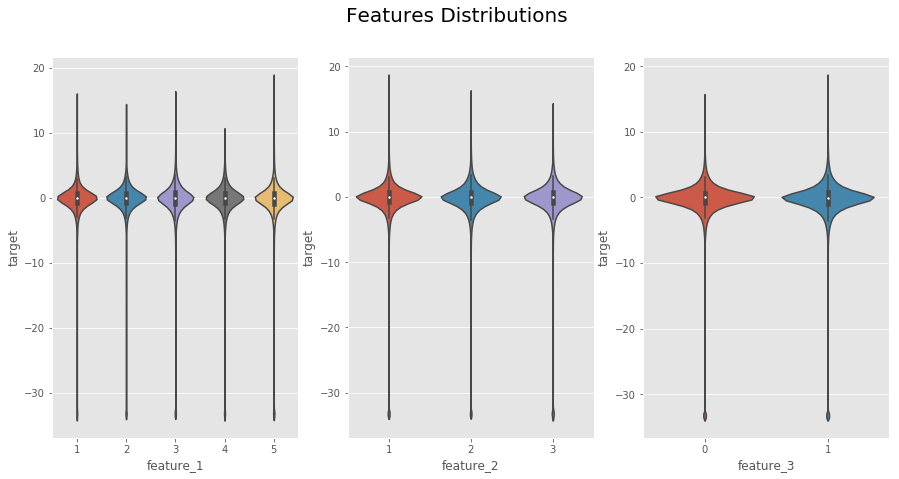

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15,7), ) 
sns.violinplot(x='feature_1', y='target', data=train, ax= ax[0])
sns.violinplot(x='feature_2', y='target', data=train, ax= ax[1])
sns.violinplot(x='feature_3', y='target', data=train, ax= ax[2])
fig.suptitle('Features Distributions', fontsize=20)
plt.show()

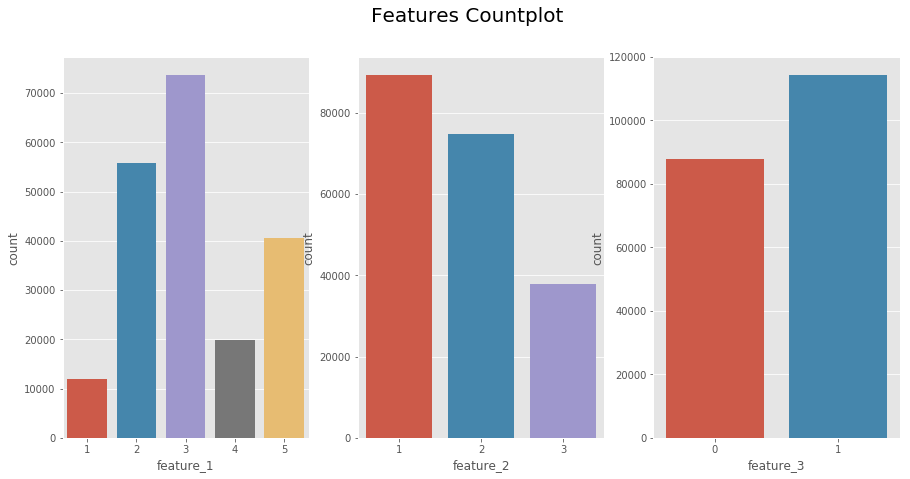

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15,7), ) 
sns.countplot(train['feature_1'], ax= ax[0])
sns.countplot(train['feature_2'], ax= ax[1])
sns.countplot(train['feature_3'], ax= ax[2])
fig.suptitle('Features Countplot', fontsize=20)
plt.show()

Although They differ in their frequencies .... still have same ***Distribution***, <br> <br> 
**Hypothesis :** these anonymized features are most likely related to the offer being served to the customer in some way ...
##### Note how all features have **mean centered at Zero** which indicates that such Normalization has been applied to such data.

###  Target

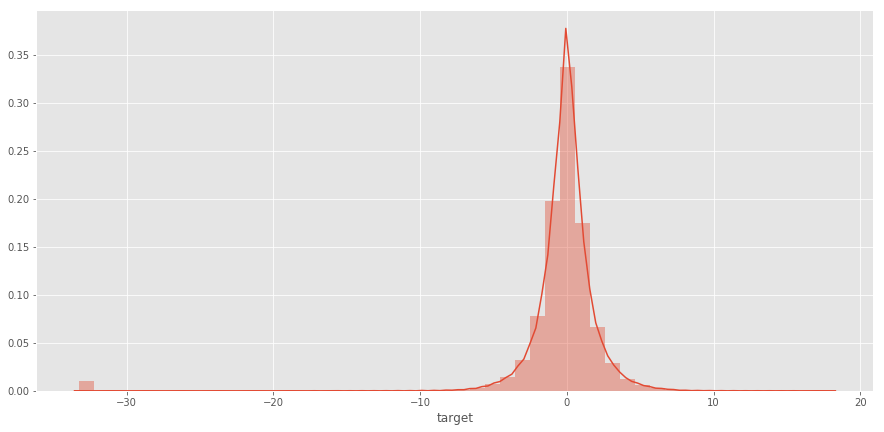

In [7]:
plt.figure(figsize=(15,7)) 
sns.distplot(train.target)
plt.show()

In [8]:
train['target'].describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

##### Distribution is highly confident with zero centered and low standard deviation, more to notice how some values are far away beyond -30

In [9]:
print("There exist {:,} being treated as outliers,All with same value {}".format(len(train[train.target < -30]), train.loc[train.target < -30, 'target'].head(1).values[0]))

There exist 2,207 being treated as outliers,All with same value -33.21928095


After some thoughts about the target variable ... it seems that it was obfuscated with `log2` transformation <br> 
which make such theory be more practical ... <br>
`
np.log2(x + 0.000_000_000_1) = -33.219280948873624
`<br>
which is the exact same number. at `x = 0`<br><br>
So summarizing what we got, <br>
#### target variable is a ratio of number of promotions used by user divided by total number of promotions sent to such user
which is then tranformed by `log2` with bias `1e-10` to hide such information.<br>
`x = 0` indicate that such customer didn't use any of the promotions recommended for him, may be not suitable promotion for him.


### Outliers

After knowing that these outliers are actually values that could occur also in test set ... which means that we should predict how to **predict them .. rather than neglecting** ... From the elo overview ...

>In this competition, Kagglers will develop algorithms to identify and
serve the most relevant opportunities to individuals, by
uncovering signal in customer loyalty. Your input will improve
customers’ lives and <b style='color:red'>help Elo reduce unwanted campaigns</b>, to create
the right experience for customers.

Therefore ... these **Outliers** are not Outliers .... they are real (existing) values which Elo is concerned about. <br>
Neglecting them, The Model will not provide anything useful for **Elo's busniess**


In [10]:
otr = -33.21928095
otr_df = train[train['target'] == otr]

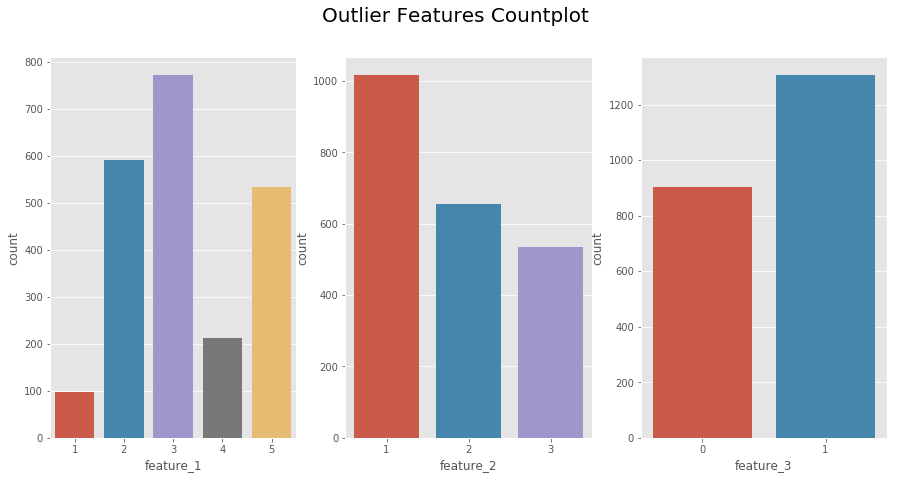

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15,7), ) 
sns.countplot(otr_df['feature_1'], ax= ax[0])
sns.countplot(otr_df['feature_2'], ax= ax[1])
sns.countplot(otr_df['feature_3'], ax= ax[2])
fig.suptitle('Outlier Features Countplot', fontsize=20)
plt.show()

the Outlier anonymized features countplots are almost identical to the whole data countplot ... which means such features are not good indicator to determine the 'outliered customer behavior' ... may be after merging the merchants' data sets going to see some insights ...

In [12]:
pd.read_excel('Data_Dictionary.xlsx', sheet_name='new_merchant_period', skiprows=2)

,Columns,Description
0,card_id,Card identifier
1,month_lag,month lag to reference date
2,purchase_date,Purchase date
3,authorized_flag,"Y' if approved, 'N' if denied"
4,category_3,anonymized category
5,installments,number of installments of purchase
6,category_1,anonymized category
7,merchant_category_id,Merchant category identifier (anonymized )
8,subsector_id,Merchant category group identifier (anonymized )
9,merchant_id,Merchant identifier (anonymized)


In [13]:
new_merch = pd.read_csv('new_merchant_transactions.csv', parse_dates=['purchase_date'])
hist_merch = pd.read_csv('historical_transactions.csv', parse_dates=['purchase_date'])

In [14]:
print("Historical merchant data with {:,} observation".format(hist_merch.shape[0]))

Historical merchant data with 29,112,361 observation


In [15]:
print("New merchant data with {:,} observation".format(new_merch.shape[0]))

New merchant data with 1,963,031 observation


In [16]:
pd.DataFrame([{
    'Customers': f'{hist_merch.card_id.nunique():,}',
    'merchants': f'{hist_merch.merchant_id.nunique():,}',
    'Transactions': f'{hist_merch.purchase_date.nunique():,}',
}]).rename(index = {0: "N"})

,Customers,Transactions,merchants
N,"325,540","16,395,300","326,311"


In [17]:
pd.DataFrame([{
    'Customers': f'{new_merch.card_id.nunique():,}',
    'merchants': f'{new_merch.merchant_id.nunique():,}',
    'Transactions': f'{new_merch.purchase_date.nunique():,}',
}]).rename(index = {0: "N"})

,Customers,Transactions,merchants
N,"290,001","1,667,025","226,129"


In [18]:
new_merch.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


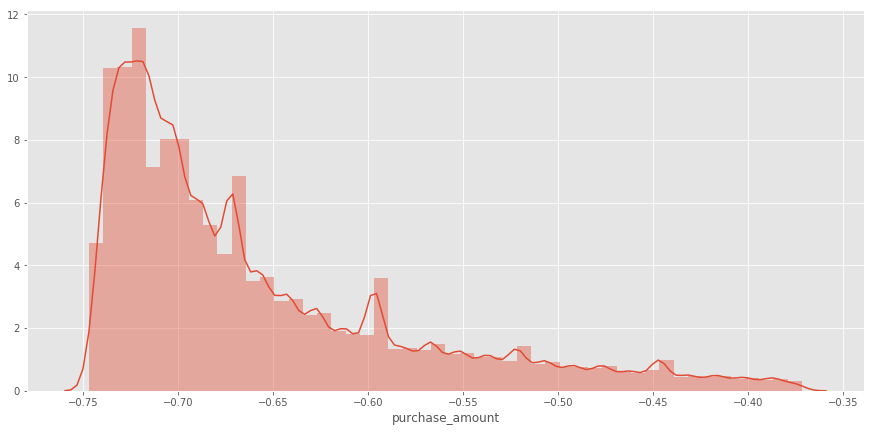

In [19]:
plt.figure(figsize=(15,7)) 
sns.distplot(new_merch[new_merch['purchase_amount']< new_merch['purchase_amount'].quantile(0.9)]['purchase_amount'])
plt.show()

In [20]:
new_merch['purchase_amount'].describe()

count    1.963031e+06
mean    -5.509690e-01
std      6.940043e-01
min     -7.468928e-01
25%     -7.166294e-01
50%     -6.748406e-01
75%     -5.816162e-01
max      2.631575e+02
Name: purchase_amount, dtype: float64

Such values are anonymized ... thinking of the most straighforward ways to do so is to demeaning and scaling, which can be reversed using some optimizations and manual tweaking ....<br>

In [21]:
new_merch['purchase_amount_new'] = pd.Series(np.round(new_merch['purchase_amount'].values / 0.00153 + 500, 2))
new_merch['purchase_amount_new'].sample(10)

323095     131.56
1176272     40.21
1087190     60.93
218432     260.30
108437      31.37
168706      88.74
371565      77.14
1693563     50.13
1714152    159.14
1621758     31.47
Name: purchase_amount_new, dtype: float64

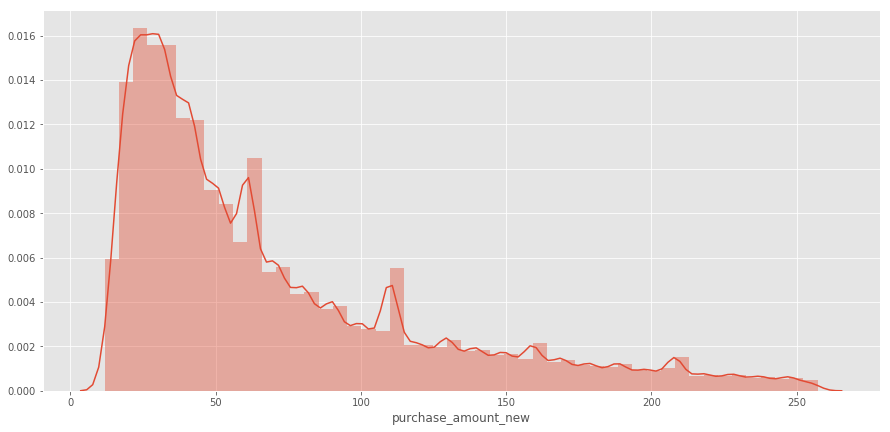

In [22]:
plt.figure(figsize=(15,7)) 
sns.distplot(new_merch[new_merch['purchase_amount_new']< new_merch['purchase_amount_new'].quantile(0.9)]['purchase_amount_new'])
plt.show()

In [23]:
new_merch['purchase_amount_new'].describe()

count    1.963031e+06
mean     1.398896e+02
std      4.535975e+02
min      1.183000e+01
25%      3.161000e+01
50%      5.893000e+01
75%      1.198600e+02
max      1.724984e+05
Name: purchase_amount_new, dtype: float64

#####  So after reverse the variable with the magic scaling and mean value ... the values now make much more sense 

## Helper Function for memory reduction

In [27]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### Feature Engineering

In [28]:
def makeDummy(df):
    for col in ['category_1', 'authorized_flag']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

In [29]:
new_merch = makeDummy(new_merch)
hist_merch = makeDummy(hist_merch)

#### month difference feature

In [30]:
hist_merch['month_diff'] = (datetime.datetime.today() - hist_merch['purchase_date']).dt.days//30
hist_merch['month_diff']+= hist_merch['month_lag']

new_merch['month_diff'] = (datetime.datetime.today() - new_merch['purchase_date']).dt.days//30
new_merch['month_diff']+= new_merch['month_lag']

In [31]:
hist_merch['purchase_month'] = hist_merch['purchase_date'].dt.month
new_merch['purchase_month'] = new_merch['purchase_date'].dt.month

#### dummies features

In [32]:
hist_merch = pd.get_dummies(hist_merch, columns=['category_2', 'category_3'])
new_merch = pd.get_dummies(new_merch, columns=['category_2', 'category_3'])

#### reduce memory

In [33]:
hist_merch = reduce_mem_usage(hist_merch)

Mem. usage decreased to 1360.42 Mb (59.2% reduction)


In [34]:
new_merch = reduce_mem_usage(new_merch)

Mem. usage decreased to 95.48 Mb (60.2% reduction)


### Aggregation Function I

In [35]:
def aggeragate_transactions(df):
    
    df['purchase_date'] = pd.DatetimeIndex(df['purchase_date']).astype(np.int64)* 1e-9 ## to apply ptp (peak to peak agg fun.)
    
    agg_funcs = {
        'authorized_flag': ['sum', 'mean'],
        'city_id' : ['nunique'],
        'category_1' : ['sum', 'mean'],
        'installments' : ['sum', 'mean', 'max', 'min', 'std'],
        'merchant_category_id' : ['nunique'],
        'merchant_id' : ['nunique'],
        'month_lag' : ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_amount' : ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_date' : [np.ptp, 'max', 'min'],
        'state_id' : ['nunique'],
        'subsector_id' : ['nunique'],
        'month_diff' : ['sum', 'mean', 'max', 'min', 'std'],
        'category_2_1.0' : ['sum', 'mean'],
        'category_2_2.0' : ['sum', 'mean'],
        'category_2_3.0' : ['sum', 'mean'],
        'category_2_4.0' : ['sum', 'mean'],
        'category_2_5.0' : ['sum', 'mean'],
        'category_3_A' : ['sum', 'mean'],
        'category_3_B' : ['sum', 'mean'],
        'category_3_C' : ['sum', 'mean'],
        'purchase_month' : ['sum', 'mean', 'max', 'min', 'std'],
    }
    
    agg_df = df.groupby(by='card_id').agg(agg_funcs)
    agg_df.columns = ['_'.join(c) for c in agg_df.columns.values]
    agg_df = agg_df.reset_index()
    
    return agg_df

In [36]:
X_base = aggeragate_transactions(hist_merch)

In [37]:
X_new = aggeragate_transactions(new_merch)

In [38]:
X_base = reduce_mem_usage(X_base)

Mem. usage decreased to 36.94 Mb (66.2% reduction)


In [39]:
X_new = reduce_mem_usage(X_new)

Mem. usage decreased to 26.83 Mb (63.4% reduction)


In [40]:
X_base.columns = ['hist_' + col if col != 'card_id' else col for col in X_base.columns.values]
X_new.columns = ['new_' + col   if col != 'card_id' else col for col in X_new.columns.values]

### Aggregation Function II

In [41]:
def double_aggregation(df):
    
    agg_func = {
        'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
        'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
    }
    
    grouped = df.groupby(by=['card_id', 'month_lag']).agg(agg_func)
    grouped.columns = ['_'.join(c) for c in grouped.columns.values]
    grouped = grouped.reset_index()
    
    ggrouped = grouped.groupby('card_id').agg(['mean', 'std'])
    ggrouped.columns = ['_'.join(c) for c in ggrouped.columns.values]
    ggrouped = ggrouped.reset_index()
    
    return ggrouped

In [42]:
X_dbgb = double_aggregation(hist_merch)

In [43]:
X_dbgb = reduce_mem_usage(X_dbgb)

Mem. usage decreased to 23.59 Mb (56.8% reduction)


In [44]:
X_dbgb.shape

(325540, 27)

In [45]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [46]:
def format_train_test(df):
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    return df

In [87]:
train = pd.read_csv('train.csv')
train = format_train_test(train)

In [88]:
test = pd.read_csv('test.csv')
test = format_train_test(test)

In [89]:
target = train['target']
del train['target']

### Merging Data-Frames

In [90]:
train = pd.merge(train, X_base, on='card_id', how='left')
test  = pd.merge(test,  X_base, on='card_id', how='left')

train = pd.merge(train, X_new, on='card_id', how='left')
test  = pd.merge(test,  X_new, on='card_id', how='left')

train = pd.merge(train, X_dbgb, on='card_id', how='left')
test  = pd.merge(test,  X_dbgb, on='card_id', how='left')

In [91]:
train.shape

(201917, 137)

In [92]:
test.shape

(123623, 137)

In [70]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_city_id_nunique,hist_category_1_sum,hist_category_1_mean,...,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,2017-06-01,C_ID_92a2005557,5,2,1,247.0,0.950195,7,0.0,0.000000,...,0.444336,0.726562,0.018188,0.032227,0.000000,0.000000,0.333252,0.500000,0.074280,0.117065
1,2017-01-01,C_ID_3d0044924f,4,1,0,339.0,0.968750,9,31.0,0.088562,...,41.781250,14.343750,1.712891,0.546875,0.692383,0.750977,6.308594,2.781250,1.478516,0.895508
2,2016-08-01,C_ID_d639edf6cd,2,2,0,41.0,0.953613,5,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2017-09-01,C_ID_186d6a6901,4,3,0,77.0,1.000000,7,12.0,0.155884,...,14.000000,11.523438,1.044922,0.215576,0.333252,1.033203,2.000000,1.095703,0.519043,0.483398
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,128.0,0.962402,6,15.0,0.112793,...,45.500000,23.984375,1.370117,0.597168,1.000000,0.000000,4.500000,5.066406,1.083008,1.664062


## Light-GBM

In [95]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [96]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = ['feature_2', 'feature_3']

In [97]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 1_000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.71525	valid_1's rmse: 3.77739
[200]	training's rmse: 3.64748	valid_1's rmse: 3.72977
[300]	training's rmse: 3.60486	valid_1's rmse: 3.70716
[400]	training's rmse: 3.574	valid_1's rmse: 3.69518
[500]	training's rmse: 3.5502	valid_1's rmse: 3.68845
[600]	training's rmse: 3.53102	valid_1's rmse: 3.68383
[700]	training's rmse: 3.51564	valid_1's rmse: 3.68103
[800]	training's rmse: 3.50196	valid_1's rmse: 3.67911
[900]	training's rmse: 3.48891	valid_1's rmse: 3.67776
[1000]	training's rmse: 3.47662	valid_1's rmse: 3.67703
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 3.47662	valid_1's rmse: 3.67703
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.7322	valid_1's rmse: 3.70661
[200]	training's rmse: 3.66266	valid_1's rmse: 3.66348
[300]	training's rmse: 3.61929	valid_1's rmse: 3.64321
[400]	training's rmse: 3.58819	valid_1's

NameError: name 'mean_squared_error' is not defined

In [106]:
print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

CV score: 3.65979 


In [103]:
oof

array([-0.26784362, -0.39758262,  0.63955891, ...,  0.0719413 ,
       -2.70124086, -0.35174306])

In [104]:
len(oof)

201917

In [105]:
train.shape

(201917, 137)

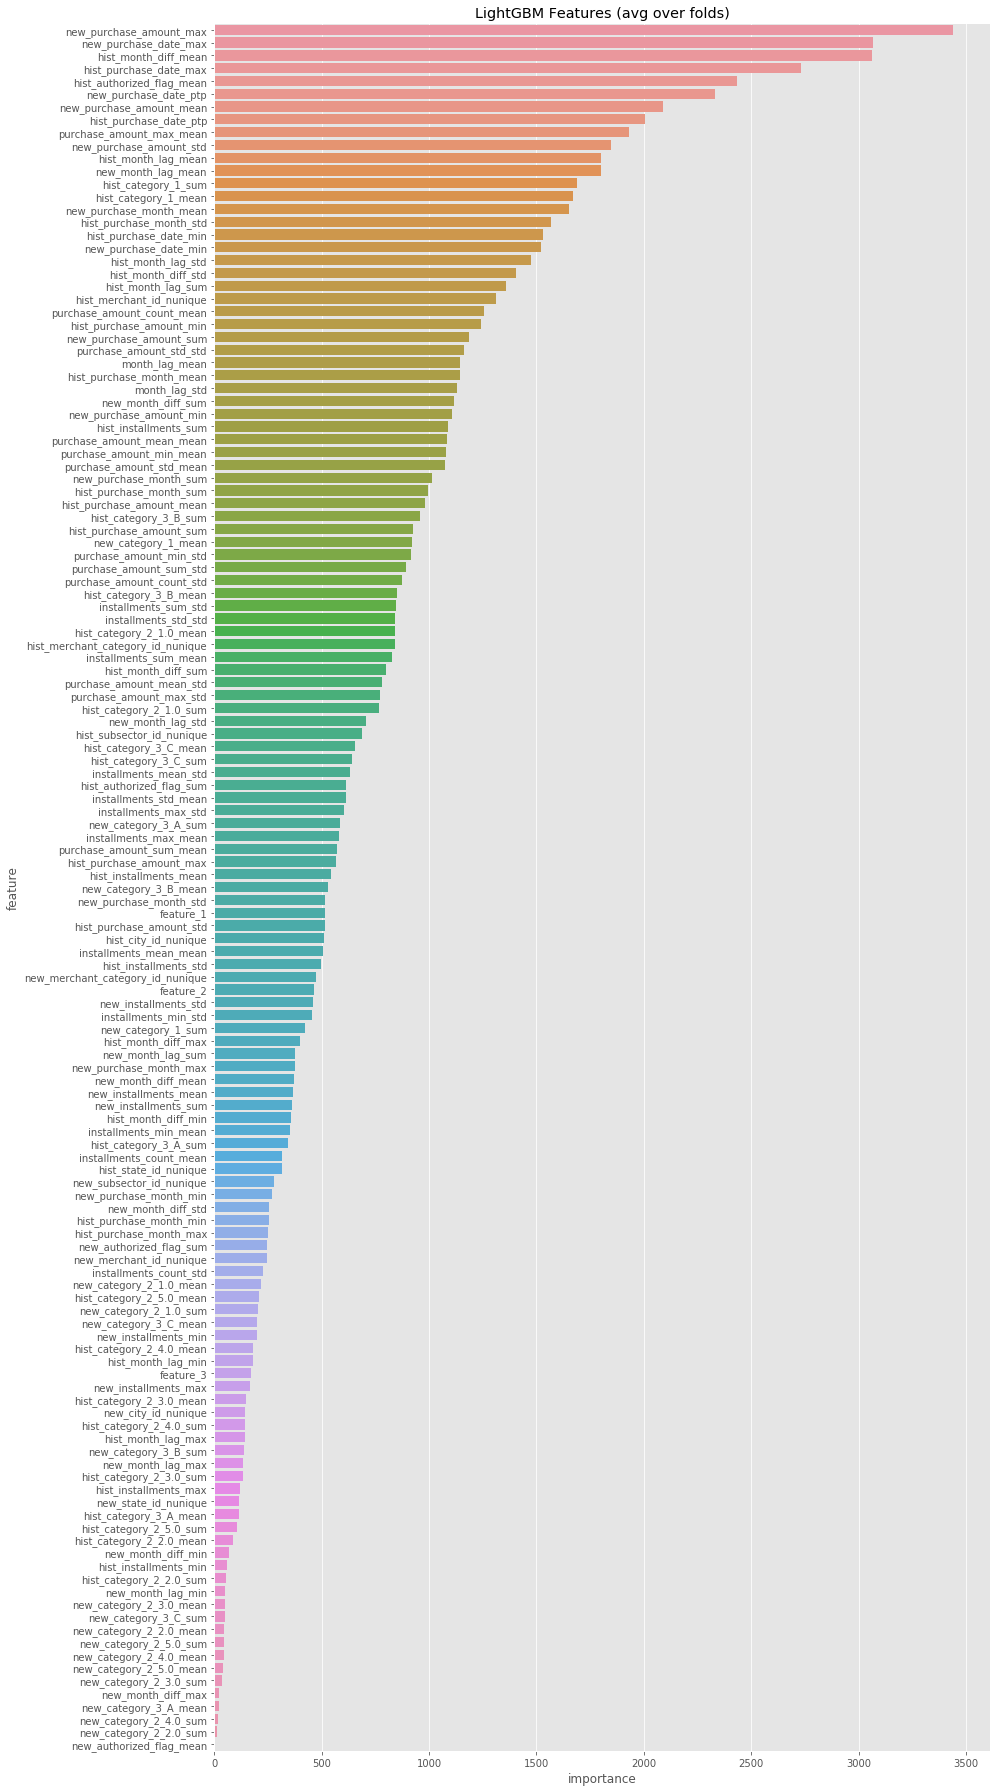

In [115]:
plt.figure(figsize=(14,25))
sns.barplot(x='importance', y='feature', data= fold_importance_df.sort_values(by='importance', ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [121]:
sub_df =pd.DataFrame({'card_id': test.card_id})
sub_df['target'] = predictions
sub_df.to_csv('light-gbm.csv', index=False)

## Ridge 

In [127]:
model = Ridge(solver = "lsqr", fit_intercept=False)

In [150]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
X_train = train[features]

X_train.fillna(0.01, inplace=True)
X_test.fillna(0.01, inplace=True)

In [171]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [172]:
model.fit(X_train, target)

Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='lsqr', tol=0.001)

In [174]:
preds = model.predict(X_test)

In [176]:
sub_df =pd.DataFrame({'card_id': test.card_id})
sub_df['target'] = preds
sub_df.to_csv('Ridge_scaled.csv', index=False)

## Neural Network 

In [198]:
from keras.layers import Dense, Activation, LeakyReLU
from keras.models import Sequential
from sklearn.model_selection import train_test_split

In [183]:
X_trains, X_vals, y_trains, y_vals = train_test_split(X_train, target, test_size = 0.1, random_state = 0)

In [212]:
model = Sequential()

model.add(Dense(32, activation='tanh', input_dim=135))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [213]:
model.fit(X_trains, y_trains, batch_size=100, epochs=100)

Epoch 1/100
181725/181725 [==============================] - 3s 15us/step - loss: 14.2969
Epoch 2/100
181725/181725 [==============================] - 2s 12us/step - loss: 13.9516
Epoch 3/100
181725/181725 [==============================] - 2s 12us/step - loss: 13.7618
Epoch 4/100
181725/181725 [==============================] - 2s 12us/step - loss: 13.6160
Epoch 5/100
181725/181725 [==============================] - 2s 12us/step - loss: 13.5270
Epoch 6/100
181725/181725 [==============================] - 2s 12us/step - loss: 13.4445
Epoch 7/100
181725/181725 [==============================] - 2s 12us/step - loss: 13.3473
Epoch 8/100
181725/181725 [==============================] - 2s 12us/step - loss: 13.2727
Epoch 9/100
181725/181725 [==============================] - 2s 12us/step - loss: 13.1710
Epoch 10/100
181725/181725 [==============================] - 2s 12us/step - loss: 13.1218
Epoch 11/100
181725/181725 [==============================] - 2s 12us/step - loss: 13.0187
Epoch 12

In [214]:
preds_nn = model.predict(X_vals)

In [215]:
print("CV score: {:<8.5f}".format(mean_squared_error(preds_nn, y_vals)**0.5))

CV score: 3.92672 
